Практический блок, рассчитайте метрики для когорты 8-14.01.2021:
*	cost
*	installs 
*	buyers 3 - плательщики 3-го дня когорты
*	buyers
*	CPM
*	IPM
*	CPI
*	ARPU_7
*	ARPPU_7
*	ARPU
*	cost per buyer 1,3,5,7,14 - цена за плательщика на указанный день когорты
*	ROAS 1,3,5,7,14,30 - фактическая окупаемость на указанный день когорты

Удобно просмотреть ответы можно в самом конце ноутбука

In [388]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)

In [389]:
ads_data = pd.read_csv('C:/Users/glebk/Desktop/ads_data.csv', parse_dates=['date'])
user_data = pd.read_csv('C:/Users/glebk/Desktop/user_data.csv', 
                        parse_dates=['attributed_touch_time','install_time', 'event_time'])
                                     

user_data[['campaign_id', 'ad_set_id', 'ad_id']] = user_data[['campaign_id', 'adset_id', 'ad_id']].fillna(0).astype('int64')
user_data.drop(labels='adset_id', axis=1, inplace=True)

In [390]:
user_data.user_id.nunique()

1220046

In [391]:
# Посмотрим NA values в данных о пользователях
user_data.isna().sum()

attributed_touch_time     831801
install_time                   0
event_time                     0
event_name                     0
event_revenue_usd        1006874
media_source              831801
channel                   831801
campaign_id                    0
ad_id                          0
country_code              102593
user_id                        0
ad_set_id                      0
dtype: int64

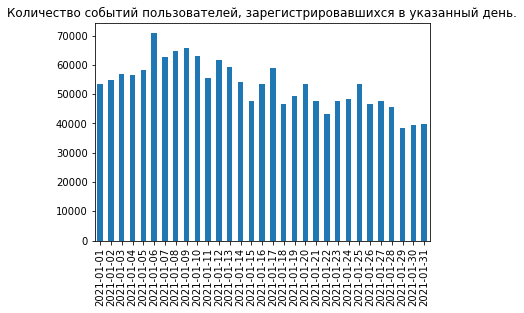

In [392]:
# Посмотрим на распределение событий по дате установки
# Чтобы понимать активность пользователей, зарегистрировавшихся в определенные дни
user_data["install_time"].dt.date.value_counts().sort_index().plot(kind='bar')
plt.title('Количество событий пользователей, зарегистрировавшихся в указанный день.')
plt.show()

In [393]:
# В install_time нет NA, или странных install_times. Сделаем по ней когорту
cohort_start = datetime.date(2021, 1, 8)
cohort_end = datetime.date(2021, 1, 14)

cohort_mask = (user_data.install_time.dt.date <= cohort_end) & (user_data.install_time.dt.date >= cohort_start)
user_cohort = user_data[cohort_mask].copy()

user_cohort.shape

(424476, 12)

In [394]:
# Посмотрим NA values в когорте

user_cohort.isna().sum()

attributed_touch_time    193195
install_time                  0
event_time                    0
event_name                    0
event_revenue_usd        258618
media_source             193195
channel                  193195
campaign_id                   0
ad_id                         0
country_code              25530
user_id                       0
ad_set_id                     0
dtype: int64

Количество инсталлов: 310351
Уникальные пользователи: 310285
Есть маленькое количество дублирующихся пользователей


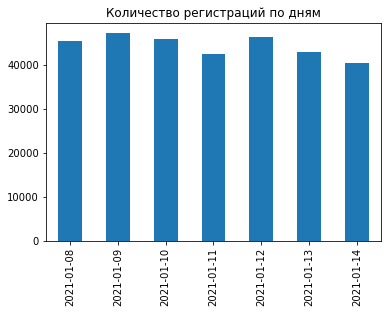

In [395]:
registration_events = user_cohort[user_cohort['event_name'].isin(['install', 'reinstall'])]
installs = registration_events.shape[0]
unique_users_count = registration_events.user_id.nunique()

print(f'Количество инсталлов: {installs}')
print(f'Уникальные пользователи: {unique_users_count}')
print(f'Есть маленькое количество дублирующихся пользователей')

# Посмотрим на распределение новых пользователей по дням когорты:
registration_events["install_time"].dt.date.value_counts().sort_index().plot(kind='bar')
plt.title('Количество регистраций по дням')
plt.show()

In [396]:
# Посмотрим,есть ли пользователи попавшие в данные с разным install time
unique_checker = user_cohort[['install_time', 'user_id']].drop_duplicates()
print(f'Уникальных пар install_time+user_id: {unique_checker.shape[0]}')
print(f'Уникальных user_id в этих парах: {unique_checker.user_id.nunique()}')
print(f'Процент записей, относящихся к пользователям с неизменным install_time: {unique_checker.user_id.nunique() / unique_checker.shape[0]}')

# Такие пользователи есть. Возможно, это пользователи, которые скачали приложение, удалили и поставили назад. 
# Необходимо изучать. Это может привести к занижению показателей при подсчете метрик на день после регистрации, ROAS 3, например.

Уникальных пар install_time+user_id: 328333
Уникальных user_id в этих парах: 310939
Процент записей, относящихся к пользователям с неизменным install_time: 0.9470232964703518


0.000000      74026
0.861978          1
0.892499          2
0.892532          1
0.892662          1
              ...  
138.992758        1
199.990000        2
202.240602        1
205.433531        1
243.923167        1
Name: event_revenue_usd, Length: 38675, dtype: int64


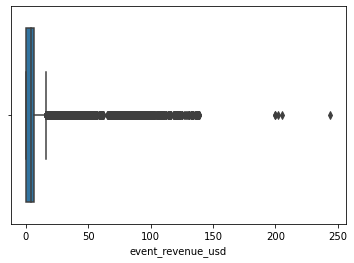

af_purchase     90826
af_subscribe     1006
Name: event_name, dtype: int64

In [397]:
# Посмотрим на распределение покупок в приложении
print(user_cohort.event_revenue_usd.value_counts().sort_index())

sns.boxplot(user_cohort.event_revenue_usd)
plt.show()

# В отсутствие контекста, все потенциальные аутлаеры могут иметь смысл.

# Посмотрим, какие события имеют revenue.
user_cohort[user_cohort['event_revenue_usd'] > 0].event_name.value_counts()

# Это только события af_purchase и af_subscribe. Имеет смысл.

In [398]:
# Посчитаем долю покупателей
buyers = user_cohort[user_cohort['event_revenue_usd'] > 0].user_id.nunique()
buyers_share = buyers*100/installs

print(f'Количество плательщиков: {buyers}')
print(f'Доля плательщиков: {buyers_share:.2f}%')

Количество плательщиков: 12022
Доля плательщиков: 3.87%


In [399]:
# Посчитаем плательщиков третьего дня.
# Мои допущения: 
# 1) Считаю плательщиков за все три дня, а не на третий день
# 2) Считаю 72 часа после регистрации, а не календарные дни.
buyers_arr = []
for i in [1, 3, 5, 7, 14]:
    mask = (user_cohort['event_time'] - user_cohort['install_time'] < pd.Timedelta(f"{i} days")) & \
            (user_cohort['event_revenue_usd'] > 0)

    buyers_arr.append(user_cohort[mask].user_id.nunique())
    
buyers_3_share = buyers_arr[1]*100/installs

print(f'Количество плательщиков 3 дня: {buyers_arr[1]}')
print(f'Доля плательщиков 3 дня: {buyers_3_share:.2f}%')

Количество плательщиков 3 дня: 6194
Доля плательщиков 3 дня: 2.00%


In [400]:
# Посчитаем ARPU и ARPPU
revenue = user_cohort.event_revenue_usd.sum()
arpu =  revenue / unique_users_count
arppu = revenue / buyers
print(f'ARPU: {arpu:.2f}')
print(f'ARPPU: {arppu:.2f}')

ARPU: 3.47
ARPPU: 89.46


In [401]:
# Посчитаем ARPU_7 и ARPPU_7.
mask = user_cohort['event_time'] - user_cohort['install_time'] < pd.Timedelta("7 days")
revenue_7 = user_cohort[mask].event_revenue_usd.sum()

arpu_7 =  revenue_7 / unique_users_count
arppu_7 = revenue_7 / buyers
print(f'ARPU_7: {arpu_7:.2f}')
print(f'ARPPU_7: {arppu_7:.2f}')

ARPU_7: 0.80
ARPPU_7: 20.75


In [402]:
# Перейдем к расчету метрик, требующих объединения данных.
# Определим, для какого количества пользователей когорты есть данные о их привлечении в приложение.

user_data_sliced = user_cohort[['campaign_id', 'ad_set_id', 'ad_id', 'user_id']].drop_duplicates()
ads_data_sliced = ads_data[['campaign_id', 'ad_set_id', 'ad_id']].drop_duplicates()

merged = pd.merge(user_data_sliced, ads_data_sliced, on=['campaign_id', 'ad_set_id', 'ad_id'], how='left', indicator='Exist')

merged['Exist'] = np.where(merged.Exist == 'both', True, False)
intersect = merged['Exist'].sum()
users_share =  intersect * 100 / merged.shape[0]

unique_users_in_intersect = merged[merged['Exist']]['user_id'].nunique()

print(f'Сочетаний кампания-пользователей в когорте: {merged.shape[0]}')
print(f'Уникальные пользователи в когорте: {unique_users_count}')
print(f'Всего пересечений между двумя таблицами: {intersect}')
print(f'Доля пересечений от всех сочетаний кампания-пользователь в когорте: {users_share:.2f}%')
print(f'Уникальных пользователей в пересечении: {unique_users_in_intersect}')

# У нас больше сочетаний кампания-пользователь, чем уникальных пользователей в когорте. Это интересное поле исследования.
# Для примерно 75% процентов пользователей нет информации о привлечении. Будем считать метрики для тех, по кому есть данные.

Сочетаний кампания-пользователей в когорте: 311009
Уникальные пользователи в когорте: 310285
Всего пересечений между двумя таблицами: 78331
Доля пересечений от всех сочетаний кампания-пользователь в когорте: 25.19%
Уникальных пользователей в пересечении: 78331


Посмотрев данные, возникает вопрос, как именно посчитать cost для нашей когорты. 
Под cost я понимаю потраченные на привлечения пользователя деньги.

Мои предположения:
 - чтобы получить cost на когорту, нужно посчитать cost, затраченный на проведение кампаний, приведших пользователей.
 - чтобы определить кампанию, приведшую пользователя, я буду использовать следующую информацию о пользователе: attributed_touch_time, страну пользователя и (campaign_id, ad_set_id, ad_id)
 - она должна матчится с соответствующей информацией о кампаниях: дата, страна(breakdowns) и (campaign_id, ad_set_id, ad_id)
 - также, в когорте есть часть пользователей без информации о кампании, предположительно органический траффик. Я не буду браь их в рассчет при подсчете CPI, ROAS и т.д.

In [403]:
# Посмотрим на кампании в данных о пользователях
user_data_camps_unique = user_cohort[['campaign_id', 'ad_set_id', 'ad_id', 'country_code']].copy()
user_data_camps_unique['date'] = user_cohort['attributed_touch_time'].dt.normalize().dt.tz_localize(None)
user_data_camps_unique = user_data_camps_unique.drop(user_data_camps_unique[user_data_camps_unique.campaign_id == 0].index)
#user_data_camps_unique['date'] = user_data_camps_unique['date'].dt.normalize
user_data_camps_unique.drop_duplicates(inplace=True)

In [404]:
# Преобразуем сами кампании и посмотрим на них
ads_data['country_code'] = ads_data['breakdowns'].str.split('"').str.get(3)
ads_data[['campaign_id', 'ad_set_id', 'ad_id', 'country_code', 'date']]

,campaign_id,ad_set_id,ad_id,country_code,date
0,23847157133130369,23847157133120369,23847157133270369,UK,2021-01-01
1,23847157133170369,23847157133180369,23847157133260369,UK,2021-01-01
2,23847157133130369,23847157133120369,23847157133250369,UK,2021-01-01
3,23847157133130369,23847157133120369,23847157133240369,UK,2021-01-01
4,23847157133130369,23847157133120369,23847157133230369,UK,2021-01-01
...,...,...,...,...,...
704809,23846826271770262,23846826271780262,23846827057460262,PT,2021-01-31
704810,23846826271770262,23846826271780262,23846827057460262,PL,2021-01-31
704811,23846826271770262,23846826271780262,23846827057460262,PH,2021-01-31
704812,23846826271770262,23846826271780262,23846827057460262,PE,2021-01-31


In [405]:
# Посмотрим, на сколько кампаний у нас есть данные
merged = pd.merge(user_data_camps_unique, ads_data, 
                  on=['campaign_id', 'ad_set_id', 'ad_id', 'country_code', 'date'], 
                  how='left', 
                  indicator='Exist')
merged['Exist'] = np.where(merged.Exist == 'both', True, False)
total_camps_with_data = merged['Exist'].sum()
print(f'Всего кампаний в пользователях: {merged.shape[0]}')
print(f'Всего кампаний в пользователях с данными: {total_camps_with_data}')

camps_with_data = merged[merged['Exist']]
camps_with_data

Всего кампаний в пользователях: 27951
Всего кампаний в пользователях с данными: 2652


,campaign_id,ad_set_id,ad_id,country_code,date,cpm,ctr,spend,clicks,impressions,breakdown_set,breakdowns,platform,Exist
0,23846486995950520,23846486995930520,23846486995940520,BA,2021-01-08,1.157094,0.920325,57.960000,461.0,50091.0,{country},"{""country"": ""BA""}",android,True
2,23846433475350520,23846433475340520,23846433475330520,SA,2021-01-07,0.983284,0.870239,27.908553,247.0,28383.0,{country},"{""country"": ""SA""}",android,True
3,23846486995950520,23846486995930520,23846486995940520,PK,2021-01-08,1.059563,2.430828,105.310000,2416.0,99390.0,{country},"{""country"": ""PK""}",android,True
6,23846513000250520,23846513000260520,23846513000270520,PL,2021-01-07,2.915551,0.901398,206.036130,637.0,70668.0,{country},"{""country"": ""PL""}",android,True
9,23846486995950520,23846486995930520,23846486995940520,RS,2021-01-08,2.356222,0.956789,181.250000,736.0,76924.0,{country},"{""country"": ""RS""}",android,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27884,23846513005790520,23846513005800520,23846513005810520,SE,2021-01-08,16.882911,1.265823,10.670000,8.0,632.0,{country},"{""country"": ""SE""}",ios,True
27886,23846487100790520,23846487100780520,23846487100770520,GN,2021-01-08,0.893855,1.117318,0.320000,4.0,358.0,{country},"{""country"": ""GN""}",ios,True
27888,23846486995950520,23846486995930520,23846486995940520,NI,2021-01-07,1.196319,0.746062,4.329477,27.0,3619.0,{country},"{""country"": ""NI""}",android,True
27918,23846487100790520,23846487100780520,23846487100770520,TG,2021-01-11,1.403509,1.754386,0.080000,1.0,57.0,{country},"{""country"": ""TG""}",ios,True


In [406]:
# Перейдем, к расчету метрик.
# Cost это общяя сумма, потраченная на компании, по которым есть информация

cost = merged['spend'].sum()
print(f'Cost: {cost:.2f}')

impressions = merged['impressions'].sum()
print(f'Показов: {impressions}')

# CPM это стоимость тясычи показов.
cpm = cost * 1000 / impressions
print(f'CPM: {cpm:.2f}')

Cost: 262211.76
Показов: 70464499.0
CPM: 3.72


In [407]:
#Чтобы высчитать CPI, нужно поделить cost на установки. Но нужны те установки, по которым есть данные о привлечении

user_cohort['date'] = user_cohort['attributed_touch_time'].dt.normalize().dt.tz_localize(None)
registration_events = user_cohort[user_cohort['event_name'].isin(['install', 'reinstall'])]

merged_installs = pd.merge(registration_events, camps_with_data.drop('Exist', axis=1),
         on=['campaign_id', 'ad_set_id', 'ad_id', 'country_code', 'date'],
         how='left', 
         indicator='Exist' 
)
merged_installs['Exist'] = np.where(merged_installs.Exist == 'both', True, False)

merged_installs[merged_installs['Exist']]
installs_winfo = merged_installs[merged_installs['Exist']].user_id.nunique()
print(f'Installs с данными: {installs_winfo}')
print(f'CPI с данными: {cost/installs:.4f}')
print(f'IPM с данными: {installs/impressions:.4f}')

Installs с данными: 76685
CPI с данными: 0.8449
IPM с данными: 0.0044


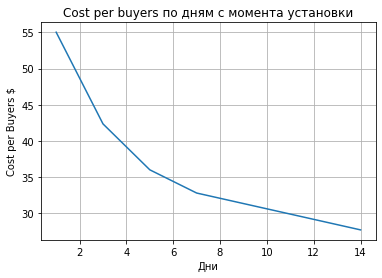

In [408]:
#Cost per buyer это cost деленный на количество buyers в определенный день после установки.

merged_events = pd.merge(user_cohort, camps_with_data.drop('Exist', axis=1),
         on=['campaign_id', 'ad_set_id', 'ad_id', 'country_code', 'date'],
         how='left', 
         indicator='Exist' 
)
merged_events['Exist'] = np.where(merged_events.Exist == 'both', True, False)

buyers_arr_winfo = []
days = [1, 3, 5, 7, 14]
for i in days:
    mask = (merged_events['event_time'] - merged_events['install_time'] < pd.Timedelta(f"{i} days")) & \
            (merged_events['event_revenue_usd'] > 0)

    buyers_arr_winfo.append(merged_events[mask].user_id.nunique())

merged_events[merged_events['Exist']]

sns.lineplot(x = days, y = cost/buyers_arr_winfo)
plt.xlabel('Дни')
plt.ylabel('Cost per Buyers $')
plt.title('Cost per buyers по дням с момента установки')
plt.grid()
plt.show()

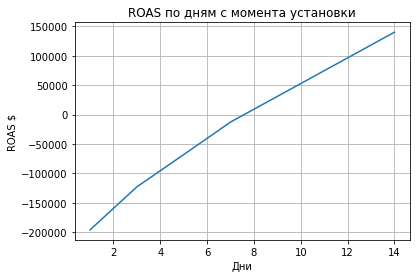

In [409]:
#ROAS это потраченные на привлечение средства - полученные от пользователей средства
revenue_arr = []
for i in days:
    mask = (merged_events['event_time'] - merged_events['install_time'] < pd.Timedelta(f"{i} days")) & \
            (merged_events['event_revenue_usd'] > 0)

    revenue_arr.append(merged_events[mask].event_revenue_usd.sum())

revenue_arr
sns.lineplot(x = days, y = revenue_arr - cost)
plt.xlabel('Дни')
plt.ylabel('ROAS $')
plt.title('ROAS по дням с момента установки')
plt.grid()
plt.show()

* Сost*: 262211.76$

* Installs: 310285

* Installs*: 76685

* Buyers 3: 7289

* Buyers 3*: 6194

* Buyers: 12022

* CPM*: 3.72

* IPM*: 0.0044

* CPI*: 0.8449

* ARPU_7: 0.80$

* ARPPU_7: 20.75$

* ARPU: 3.47$

Cost per buyer и ROAS:

|  | День 1 | День 3 | День 5 | День 7 | День 14 |
| --- | --- | --- | --- | --- | --- |
| Cost per buyer | 55.02 | 42.33 | 35.97 | 32.76 | 27.65 |
| ROAS | -196059 | -12288 | -68060 | -12739 | 140029 |

Cost per buyer и ROAS на графиках выше.

(*) Означает, что данные посчитаны только для пользователей с информацией о их привлечении